In [1]:
import torch
import transformers
from fastai.text.all import *
import fastai
import re
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import (
    PreTrainedTokenizerFast,
    AutoModelWithLMHead,
    PreTrainedTokenizerFast
) 
import torch
import torch.nn as nn
import math
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split
from datasets import Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import chardet
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

c:\brain_tumor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1+cu118
4.47.0
2.7.18


In [2]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
text = """옛날에 백설공주가 살고 있었어요."""
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
c:\brain_tumor\venv\Lib\site-packages\transformers\models\auto\modeling_auto.py:1838: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
옛날에 백설공주가 살고 있었어요."
"그런데 그게 무슨 소리야? 난 지금 이 순간에도 내 앞에 서 있는 거예요! 내가 왜 이렇게 무섭고 무서운지 알겠는데."
나는 고개를 끄덕였다.
그리고는 다시 한 번 말했다.
'내가 너를 사랑하고 있다는 걸 알고 있어.'
이렇게 말하고 나서 나는 눈을 감았다.
아무것도 보이지 않았다.
눈을 감고 있던 눈물이 흘러내렸다.
내 눈에 비친 것은 아무것도 없었다.
하지만 그것은 나의 마음속에 있었다.
나의 눈은 이미 나를 향해 열려져 있었고, 그리고 그의 마음은 여전히 나에게 고정되어 있었던 것이다.
그러나 그는 내게로 다가오고 있었다. 만약 그가 나와 함께


In [3]:
import os
import re
import chardet

def clean_text(text):
    text = re.sub(r'[^\w\sㄱ-힣,.!?]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'읽어주셔서 감사합니다','',text)
    text = re.sub(r'동화 끝','',text)
    text = re.sub(r'^\d+\.','',text)
    return text

def preprocess_text(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Detect file encoding
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    encoding = result['encoding'] or 'utf-8' 
    print(f"Detected encoding: {encoding}")

    with open(file_path, 'r', encoding=encoding) as f:
        lines = f.readlines()

    cleaned_lines = [clean_text(line.strip()) for line in lines if line.strip()]

    if not cleaned_lines:
        raise ValueError("The file contains no valid text after preprocessing.")

    return " ".join(cleaned_lines)

file_path = 'processed_data.txt'
try:
    preprocessed_texts = preprocess_text(file_path)
    print("Text preprocessing completed.")
except Exception as e:
    print(f"Error: {e}")


Detected encoding: utf-8
Text preprocessing completed.


In [4]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=preprocessed_texts[:int(len(preprocessed_texts)*0.9)]
test=preprocessed_texts[int(len(preprocessed_texts)*0.9):]
splits = [[0],[1]]

tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
# dls.show_batch(max_n=2)

c:\brain_tumor\venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\brain_tumor\venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


c:\brain_tumor\venv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs)


SuggestedLRs(valley=4.365158383734524e-05)


epoch,train_loss,valid_loss,perplexity,time
0,3.950958,3.807051,45.017483,00:30
1,3.583727,3.750771,42.553879,00:40
2,3.232438,3.736058,41.932346,00:40
3,2.953466,3.729425,41.655159,00:44
4,2.797915,3.728603,41.620907,00:46


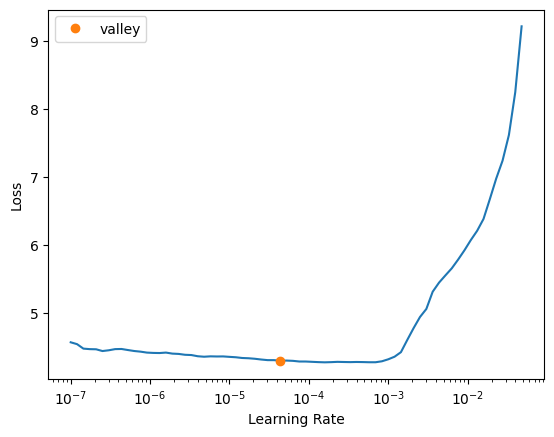

In [5]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(5, lr)
# learn.fine_tune(3)

In [6]:
prompt="옛날에 백설공주가 살고 있었어요."
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'옛날에 백설공주가 살고 있었어요. 하지만 그녀는 너무도 아름다웠기에 그녀의 미모에 대해선 아무도 몰랐답니다. 그래서 그녀가 자신의 연인인 롤랑에게 말했지요, 사랑하는 여동생이여, 저를 사랑하셔서 제가 당신을 위해 이 아름다운 드레스 한 벌만 주세요! 그러자 처녀가 대답하기를, 제게 그걸 주신다면 감사하겠습니다.라고 했죠. 그런 다음 그녀와 함께 길을 떠났는데, 거기서 우연히 두 자매들이 서로 마주쳤는데 말이야 뭐 어째?라며 그가 물었더니, 그들은 왕자님과 결혼식을 올렸잖아요?\n그런데 왜 안 된다, 우리 둘'

In [7]:
learn.model.save_pretrained("kogpt2novel_backup")